## Spatial Autocorrelation and Regression Analysis
In this tutorial, you will calculate a global Moran's I statistic to evaluate spatial autocorrelation in your data, and then explore different methods to account for spatial autocorrelation in your data. Specifically, we'll compare parameter estimates relating county income to 2016 county voting preferences using an OLS model, and autoregressive model, and an autocovariance function model.


In [3]:
import pysal as ps
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights.contiguity import Queen
import libpysal
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from esda.moran import Moran_Local
from esda.moran import Moran
from statsmodels.api import OLS
from pysal.model import spreg
sns.set_style('white')

First, we're going to open 'Elections' dataset from the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

Using our multicollinearity.ipynb, we downloaded this dataset to *H:/EnvDatSci/election/election.shp*

**Note: it may be on a different location on your computer**

### TASK 1: if neccessary, edit the filepath below to access the "election" shapefile downloaded in the multicollinearity.ipnb script

In [35]:
# Task 1: is this the correct filepath on your computer? Change it!
votes = gpd.read_file('H:/EnvDatSci/election/election.shp')

<AxesSubplot:>

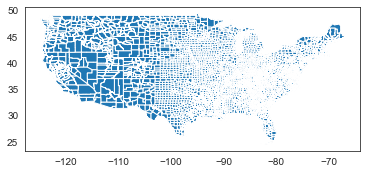

In [5]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [6]:
#View the first few line]s of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.42720 31.26436, -87.42551 31.268..."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.41333 32.75059, -86.37115 32.750..."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87046 32.76244, -87.86818 32.765..."


In our multicollinearity notebook, we visualized the voting trends, and the change in voting trends, in space. First we created a new column indicating the percent change in democratic vote. Then we plotted the percent democratic vote in 2012, the percent democratic vote in 2016, and the percent change in democratic vote as maps and using global histograms.

C:\Apps-SU\Anaconda3\envs\geostats_env\lib\site-packages\seaborn\distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
C:\Apps-SU\Anaconda3\envs\geostats_env\lib\site-packages\seaborn\distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
C:\Apps-SU\Anaconda3\envs\geostats_env\lib\site-packages\seaborn\distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


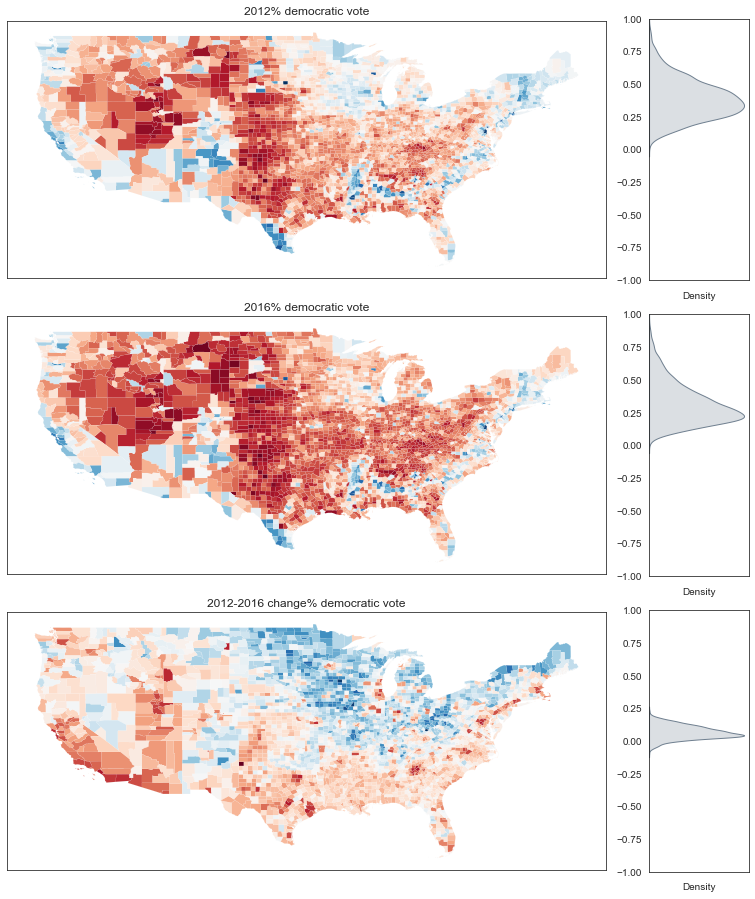

In [10]:
# Add new column pct_dem_change to votes:
votes['pct_dem_change'] = votes['pct_dem_12'] - votes['pct_dem_16']

f,ax = plt.subplots(3,2, figsize=(1.6*6 + 1,4.2*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16', 'pct_dem_change']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016', '2012-2016 change'][i] + "% democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### Spatial Autocorrelation
From https://www.sciencedirect.com/topics/computer-science/spatial-autocorrelation 

>"Spatial autocorrelation is the term used to describe the presence of *systematic* spatial variation in a variable and positive spatial autocorrelation, which is most often encountered in practical situations, is the tendency for areas or sites that are close together to have similar values."

### TASK 2: Do you see evidence for *spatial autocorrelation* in the three plots above? If so, describe the evidence that you see.

*Type answer here.*

## Was the county wide percent change in democratic vote related to per capita income?
The next question is how can we use robust statistics to determine whether per capita income was related to a chance in 2016 voting preferences. To do this, we're going to conduct a linear regression relating our parameters in pct_dem_change to INC910213. Then, we're going to use the confidence interval around beta hat (our slope parameter estimate) to determine whether the relationship between INC910213 and pct_dem_change is significantly different than zero.

First we're going to visualize how these variables relate in the global data:

In [12]:
votes.dropna(subset=['pct_dem_12','pct_dem_16'], inplace=True)

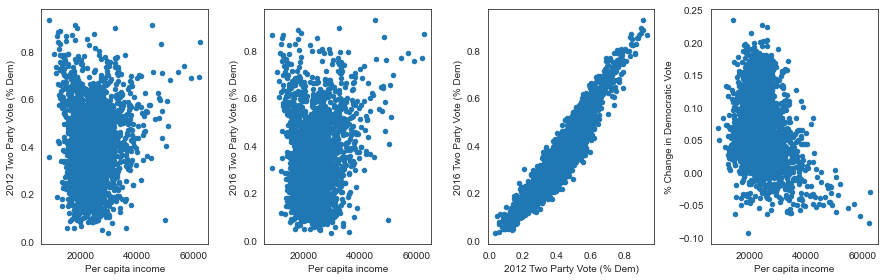

In [17]:
f,ax = plt.subplots(1,4, figsize=(4*3.1,4))
votes[['INC910213','pct_dem_12']].plot.scatter('INC910213','pct_dem_12', ax=ax[0])
ax[0].set_xlabel('Per capita income')
ax[0].set_ylabel('2012 Two Party Vote (% Dem)')
r = np.corrcoef(votes['pct_dem_16'].values, votes['pct_dem_12'].values)[0,1]

votes[['INC910213','pct_dem_16']].plot.scatter('INC910213','pct_dem_16', ax=ax[1])
ax[1].set_xlabel('Per capita income')
ax[1].set_ylabel('2016 Two Party Vote (% Dem)')
r = np.corrcoef(votes['INC910213'].values, votes['pct_dem_16'].values)[0,1]

votes[['pct_dem_12','pct_dem_16']].plot.scatter('pct_dem_12','pct_dem_16', ax=ax[2])
ax[2].set_xlabel('2012 Two Party Vote (% Dem)')
ax[2].set_ylabel('2016 Two Party Vote (% Dem)')
r = np.corrcoef(votes['pct_dem_12'].values, votes['pct_dem_16'].values)[0,1]


votes[['INC910213','pct_dem_change']].plot.scatter('INC910213','pct_dem_change', ax=ax[3])
ax[3].set_xlabel('Per capita income')
ax[3].set_ylabel('% Change in Democratic Vote')
r = np.corrcoef(votes['pct_pt_16'].values, votes['INC910213'].values)[0,1]

f.tight_layout()
plt.show()

What we're looking at in the first plot is the 2012 percent democratic vote, the second plot is the 2016 percent democratic vote, the third plot is the 2012 and 2016 percent democratic vote. In the fourth plot, we're looking at how per capital income (x axis) relates to % change in democratic vote. We want to establish a trendline in the fourth plot using linear regression, and determine of the slope in that trendline is statistically significant.

### TASK 3: what are some features of this data that it look well-suited for linear regression? What are some features of this data that make it poorly suited for linear regression?

*Type answer here.*

## Do we have spatial autocorrelation in our data?
When we're looking at distributions of voting preferences, remember that we're aggregating these numbers over arbitrary (er...political) geographic regions. 

Each column in that dataframe represents a data value summarized over a US county, but US counties have widely different land areas and populations:

Text(0.5, 0, '2014 County Population')

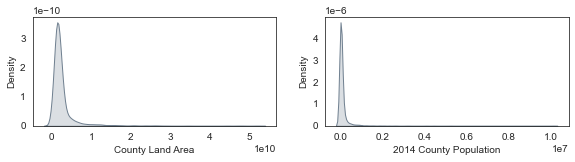

In [18]:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
sns.kdeplot(votes['ALAND'].values, shade=True, color='slategrey', ax=ax[0])
ax[0].set_xlabel('County Land Area')

sns.kdeplot(votes['PST045214'].values, shade=True, color='slategrey', ax=ax[1])
ax[1].set_xlabel('2014 County Population')

Our *spatial sampling rate* (by county) may not accurately represent the spatial frequency of variability in voting preferences and/or income. 

First, let's focus on the spatial componnet: the fact that these counties are different sizes. 

If we want to identify spatial autocorrelation in our data, we need to first understand how this spatial autocorrelation decays as a function of distance. 

To do this, we calculate the Moran's I statistic, which you can think of as the "slope" that we'd get when we regress data values for all geographic entities with data values that neighbor within a given distance. Lets look at our data in lat/lon space again:

<AxesSubplot:>

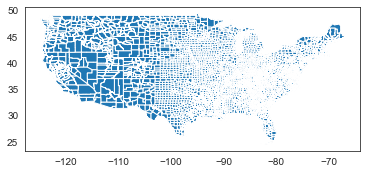

In [19]:
votes.plot()

In [45]:
votes.crs

{'proj': 'eqc',
 'lat_ts': -66.09421768,
 'lat_0': 0,
 'lon_0': 0,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

### TASK 4: What is the horizontal unit (unit of distance) in our votes data?

*Type answer here.*

One issue is that we're sampling spatially at a distinct, and heterogenous, granulatiry. The smallest unit of measurement available in our dataset is the county level. Counties are different sizes. How can we evaluate whether this spatial sampling granularity is of sufficient resolution to capture the scale of variability in our dataset?

* If we are sampling at too course of a spatial scale, we run the risk of missing key patterns of variability in our data (**UNDERSAMPLING**) 

* If we are sampling at too fine of a sptial scale, we run the risk of violating assumptions of independence between our individual observations (**OVERSAMPLING**)

### TASK 5: In your own words, describe how the spatial sampling scale of "county" might represent and oversampling or undersampling of data as it relates to our question (did per capital income impact change in voting preference

*Type answer here.

## Calculating a weights matrix:
The first thing we want to tackle is a quantification of any spatial autocorrelation in our dataset. Spatial autocorrelation inflates our theoretical number of samples (N), artificially increasing the power in our test statistics. In other words, when we're calculating test statistics, spatial autocorrelation in our data can make it seem like parameters that are unimportant are actually significant.

Since we're dealing with a heterogeneous sampling grid in our data, the first thing we want to do is calculate a weights matrix.

We're going to use the Queen function in pysal to do this. Full documentation here: https://pysal.org/libpysal/generated/libpysal.weights.Queen.html

Or just use the built in help with the function below:

In [46]:
??Queen

#Click the "X" in the upper right corner of that help window that pops up to close it.

C:\Apps-SU\Anaconda3\envs\geostats_env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 1267, 2729, 2763.
  warnings.warn(message)


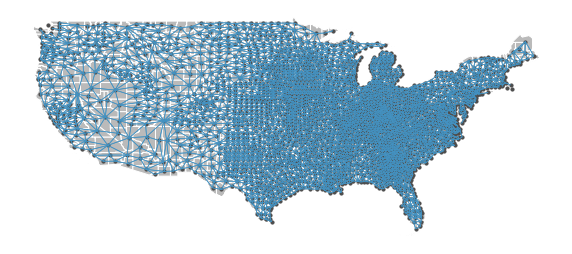

In [47]:
#Calculate weights object
weights = Queen.from_dataframe(votes)

#Use built in plot function to visualize how the weights matrix works
plot_spatial_weights(weights, votes)
plt.show()

The verticies in this plot represent two things: 
* First, they link "neigbors" based on the model parameters we set for defining neighborhood (here we use the defaul settings and consider any contiguous polygons). 
* The length of the verticies indicates the distance between the centers of neighborhing cells. 

"Neighbors" that are father matter less than "neighbors" that are closer in identifying the strength of spatial autocorrelation.

## Calculate Moran's I:
Moran's I statistic quantifies the spatial autocorrelation in your data. From https://en.wikipedia.org/wiki/Moran%27s_I
>"Spatial dependency leads to the spatial autocorrelation problem in statistics since, like temporal autocorrelation, this violates standard statistical techniques that assume independence among observations. For example, regression analyses that do not compensate for spatial dependency can have unstable parameter estimates and yield unreliable significance tests. Spatial regression models (see below) capture these relationships and do not suffer from these weaknesses. It is also appropriate to view spatial dependency as a source of information rather than something to be corrected."

('WARNING: ', 1267, ' is an island (no neighbors)')
('WARNING: ', 2729, ' is an island (no neighbors)')
('WARNING: ', 2763, ' is an island (no neighbors)')


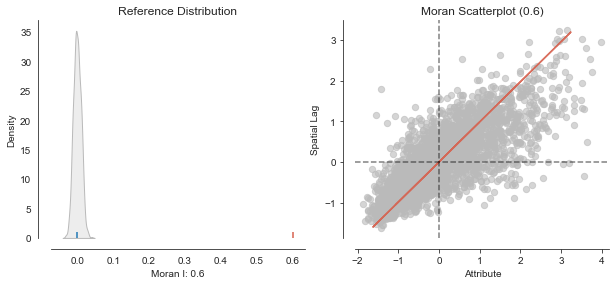

In [48]:
# calculate Moran and plot
moran = Moran(votes['pct_dem_16'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### TASK 6: Do we have statistically significant evidence (at alpha = 0.05) of spatial autocorrelation in our response variable (Percent change in democratic vote, or pct_pt_16)?
Use code cell below as your "calculator". 

*Type answer here.*

In [ ]:
# What is the null hypothesis?
# What is the alternative hypothesis?
# What is our test statistic?
# How can we derive the test statistic from our "moran" object?
# HINT:
?moran

## Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether that analysis determines a statistically significant relationship between our percent income and percent change in democratic vote.

In [49]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes['PST045214'].values)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_16'].values)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [50]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.170
Model:                            OLS   Adj. R-squared (uncentered):              0.170
Method:                 Least Squares   F-statistic:                              636.1
Date:                Tue, 09 Nov 2021   Prob (F-statistic):                   7.61e-128
Time:                        13:23:26   Log-Likelihood:                         -873.69
No. Observations:                3108   AIC:                                      1749.
Df Residuals:                    3107   BIC:                                      1755.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### TASK 7: Do we have statistically significant evidence (at alpha = 0.05) of a statistically significant relationship between pct_pt_16 and PST045214? How does PST045214 impact pct_pt_16? Use numbers to back your claim.

*Type answer here.*

Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [51]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=lm.fit().resid

Remember, in OLS regression we depend out our residuals being normally distributed:

Text(0.5, 16.200000000000003, 'OLS residuals')

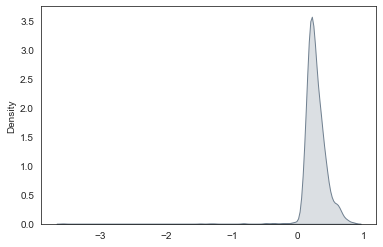

In [52]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('OLS residuals')

<AxesSubplot:>

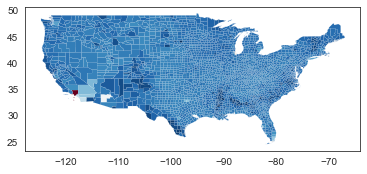

In [53]:
#Plot them in space:
votes.plot('lm_resid', linewidth=.05, cmap='RdBu')

So, these are very not normal residuals. What's going on?

### TASK 8: What does a positive residual mean here (the model overpredicted change in democratic vote, the model underpredicted change in democratic vote)?
One way we can evaluate whether spatial autocorrelation has impacted our results is if we see spatial autocorrelation in the residuals:

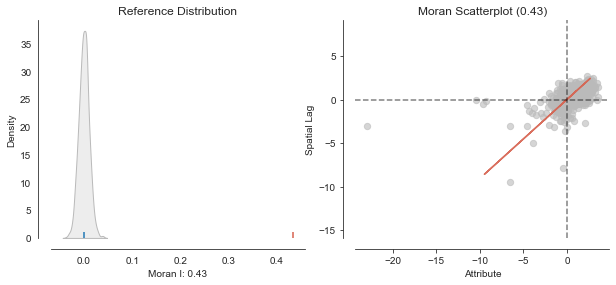

In [54]:
# calculate Moran and plot
moran = Moran(votes['lm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### TASK 9: Do we have correlated residuals (use numbers to back your answer)?

*Type answer here.*

## Autocovariate regression: spatial lag model
Let's see if we can get different answers by accounting for our residuals in our model. First, we'll try a spatial lag model. A spatial lag model is a type of autocovariate model that assumes that dependencies exist directly among the levels of the dependent variable, and models them as an "autocovariate". So we create an autocovariate function that describes the degree to which the percent change in democratic vote at one location is affected by the percent change in democratic vote at the nearby locations. The coefficient and p-value for the autocovariate function are interpreted as for the independent variables.

In [56]:
X = np.array(votes['PST045214'].values).T
X.shape = (len(Y),1)
Y = np.array(votes['pct_dem_16'].values).T
Y.shape = (len(Y),1)

lag=spreg.ML_Lag(Y, X, weights)
print(lag.summary)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        3108
Mean dependent var  :      0.3167                Number of Variables   :           3
S.D. dependent var  :      0.1533                Degrees of Freedom    :        3105
Pseudo R-squared    :      0.5986
Spatial Pseudo R-squared:  0.1551
Sigma-square ML     :       0.010                Log likelihood        :    2584.230
S.E of regression   :       0.099                Akaike info criterion :   -5162.461
                                                 Schwarz criterion     :   -5144.336

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

Text(0.5, 16.200000000000003, 'SLM residuals')

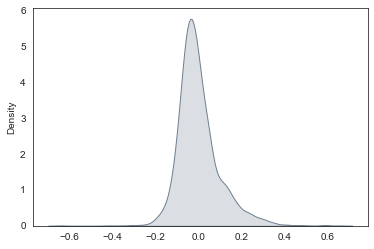

In [57]:
#Add model residuals to our "votes" geopandas dataframe:
votes['slm_resid']=lag.u
sns.kdeplot(votes['slm_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('SLM residuals')

<AxesSubplot:>

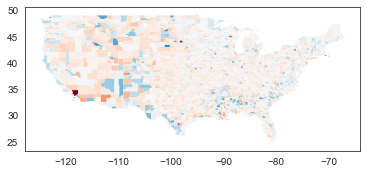

In [58]:
#Plot them in spac:
votes.plot('slm_resid', linewidth=.05, cmap='RdBu')

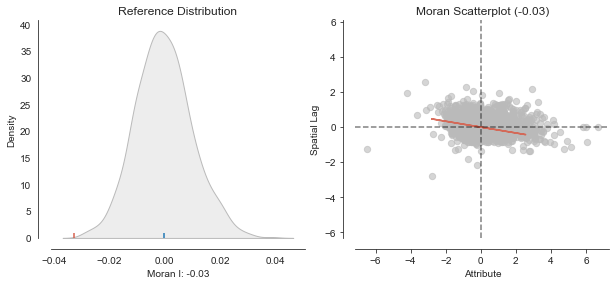

In [59]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### TASK 10: When we account for spatial autocorrelation in our data using the spatial lag model, do we still see a significant relationship between our response and predictor variable? Do you think this is a valid approach? Why or why not?

*Type answer here.*

## Spatial autoregressive model (maximum likelihood spatial error model)
Instead of modelling spatial dependence using an autocovariate, we use a similar type of weight structure (here called "lambda") to weight the error matrix:

In [ ]:
error = spreg.ML_Error(Y, X, weights)
print(error.summary)

In [ ]:
#Add model residuals to our "votes" geopandas dataframe:
votes['mlError_resid']=error.u
sns.kdeplot(votes['mlError_resid'].values, shade=True, color='slategrey')
ax[1].set_xlabel('MLError residuals')

In [ ]:
#Plot them in spac:
votes.plot('slm_resid', linewidth=.05, cmap='RdBu')

In [ ]:
# calculate Moran and plot
moran = Moran(votes['slm_resid'], w=weights)
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

### TASK 11: Given these three models, do you believe that there is a relationship between percent change in democratic vote and income level? Why or why not?

*Type answer here.*